# Loading data

In [2]:
import numpy as np
import pandas as pd
import sklearn.linear_model as skl
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler


In [3]:
oferagregadocortado = pd.read_csv('Bases finais/ofestim.csv')
oferagregadocompleto = pd.read_csv('Bases finais/ofestimfull.csv')
bancodemanda = pd.read_csv('Bases finais/basedemandaeleitoral.csv')
ofertacompleto = pd.read_csv('Bases finais/baseofertaeleitoral.csv')

In [7]:
ofer = ofertacompleto.copy()
ofer = ofer[(ofer.N_apelo >=91) & (ofer.Peças_TV >=7)].reset_index(drop=True)
ofer.shape

(46171, 38)

In [4]:
dem = bancodemanda.copy()

dem['peso'] = dem['peso'].replace({'Unweighted':1})


# Recoding Trust in Parties Variable

def remap_category(value):
    if value == "A lot":
        return 3
    elif value == "Some":
        return 2
    elif value == "A little":
        return 1
    elif value == "No confidence at all":
        return 0
    else:
        return pd.NA
    
def remap_category_econ(value):
    if value == "Very Good":
        return 4
    if value == "Good":
        return 3
    elif value == "About Average":
        return 2
    elif value == "Bad":
        return 1
    elif value == "Very Bad":
        return 0
    else:
        return pd.NA

dem['conf_part2'] = dem['conf_part'].map(remap_category)
dem['conf_cong2'] = dem['conf_cong'].map(remap_category)
dem['conf_presi2'] = dem['conf_presi'].map(remap_category)
dem['sit_econ2'] = dem['sit_econ'].map(remap_category_econ)
dem['sit_econ2_invert'] = 4 - dem['sit_econ2']

dem = dem.astype({'sit_econ2':'Int64','sit_econ2_invert':'Int64', 'conf_part2':'Int64', 'peso':'float64', 'ano_eleicao':'category'})
dem.shape

(43178, 15)

In [37]:
ofestimfull = oferagregadocompleto.copy()


dem2 = dem.dropna(subset='conf_part2')

agruconf = dem2.groupby(['pais', 'ano_eleicao'],  
                           observed= False).apply(lambda x: np.average(x['conf_part2'], weights=x['peso']),
                           include_groups=False).reset_index()
agruconf.rename(columns={0:'conf_part2'}, inplace = True)

dem2 = dem.dropna(subset='conf_cong2')

agruconf1 = dem2.groupby(['pais', 'ano_eleicao'],  
                           observed= False).apply(lambda x: np.average(x['conf_cong2'], weights=x['peso']),
                           include_groups=False).reset_index()

agruconf1.rename(columns={0:'conf_cong2'}, inplace = True)

dem2 = dem.dropna(subset='conf_presi2')

agruconf2 = dem2.groupby(['pais', 'ano_eleicao'],  
                           observed= False).apply(lambda x: np.average(x['conf_presi2'], weights=x['peso']),
                           include_groups=False).reset_index()

agruconf2.rename(columns={0:'conf_presi2'}, inplace = True)

dem3 = dem.dropna(subset='sit_econ2')

agruecon = dem3.groupby(['pais', 'ano_eleicao'], observed=False).apply(lambda x: np.average(x['sit_econ2'], weights=x['peso']),
                                                         include_groups=False).reset_index()

agruecon.rename(columns={0:'sit_econ2'}, inplace = True)

dem3 = dem.dropna(subset='sit_econ2_invert')

agruecon_invert = dem3.groupby(['pais', 'ano_eleicao'], observed=False).apply(lambda x: np.average(x['sit_econ2_invert'], weights=x['peso']),
                                                         include_groups=False).reset_index()

agruecon_invert.rename(columns={0:'sit_econ2_invert'}, inplace = True)

ofestimfull = pd.merge(ofestimfull, agruconf, how='left', on=['pais', 'ano_eleicao'])
ofestimfull = pd.merge(ofestimfull, agruconf1, how='left', on=['pais', 'ano_eleicao'])
ofestimfull = pd.merge(ofestimfull, agruconf2, how='left', on=['pais', 'ano_eleicao'])
ofestimfull = pd.merge(ofestimfull, agruecon, how='left', on=['pais', 'ano_eleicao'])
ofestimfull = pd.merge(ofestimfull, agruecon_invert, how='left', on=['pais', 'ano_eleicao'])

# Calculating electoral stress index with economical perception

ofestimfull['grau_est'] = 1 - (((ofestimfull['sit_econ2']/4) + (ofestimfull['conf_part2']/3))/2)
ofestimfull['grau_estcong'] = 1 - (((ofestimfull['sit_econ2']/4) + (ofestimfull['conf_cong2']/3))/2)

# Calculating electoral stress index with GDP variation

ofestimfull['grau_estp'] = 1 - (((ofestimfull['var_anual_PIBpercapita']) + (ofestimfull['conf_part2']/3))/2)
ofestimfull['grau_estpcong'] = 1 - (((ofestimfull['var_anual_PIBpercapita']) + (ofestimfull['conf_cong2']/3))/2)
ofestimfull = pd.get_dummies(ofestimfull , columns = ['Situacao_oposicao'])
ofestimfull['opind'] = [not value for value in ofestimfull.Situacao_oposicao_Situação]

ofestim = ofestimfull[(ofestimfull.N_apelo >=91) & (ofestimfull.Peças_TV >=7)].reset_index(drop=True)
#ofestim.to_csv('Bases finais/ofestim96.csv', index=False)
ofestim.shape


(96, 47)

In [583]:

ofer1 = pd.merge(ofer, ofestim[['pais', 'ano_eleicao', 'candidato', 'apelos_ativos', 'neutralidade_apelo', 'IMP', 
                             'conf_part2', 'conf_cong2', 'conf_presi2', 'sit_econ2', 'grau_est']],
              how ='left', on=['pais', 'ano_eleicao', 'candidato'])

ofer1.shape

(46171, 46)

In [421]:
print(f'dem: {dem.columns}', '\n''\n', f'ofestim: {ofestim.columns}', '\n''\n', f'ofer: {ofer1.columns}')

dem: Index(['pais', 'ano_survey', 'ano_eleicao', 'peso', 'posi_pol', 'sit_econ',
       'princ_prob', 'conf_cong', 'conf_part', 'conf_presi', 'conf_part2',
       'conf_cong2', 'conf_presi2', 'sit_econ2'],
      dtype='object') 

 ofestim: Index(['pais', 'ano_eleicao', 'candidato', 'tipo_apelo', 'apelos_ativos',
       'neutralidade_apelo', 'Orientacao', 'Candidato_minoria', 'Incumbente',
       'Situacao_oposicao', 'Partidos', 'Votos_1T', 'Votos_2T', 'Peças_TV',
       'Tempo total (minutos)', 'Tempo total (segundos)',
       'Tempo total (HH:MM:SS)', 'Eleito', 'eleicao_2turnos',
       'candidato_2turno', 'Link eleição', 'var_anual_PIBpercapita', 'HDI',
       'GNI', 'inflacao_CPI', 'Gini_index', 'desemprego', 'N_apelo',
       'dif_votos', 'polariz', 'princ_tema_maincats',
       'princ_probelec_maincats', 'match_probtema_maincats', 'IMP',
       'conf_part2', 'conf_cong2', 'conf_presi2', 'sit_econ2', 'grau_est'],
      dtype='object') 

 ofer: Index(['pais', 'ano_eleicao', 'candida

# Standardizing variables

In [6]:

# Centering the continous variables to reduce structural multicolinearity and improving standard errors 
# (https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)

av = ofestim.copy()
av['IMP'] = av['IMP'] - av['IMP'].mean()
av['sit_econ2'] = av['sit_econ2'] - av['sit_econ2'].mean()
av['sit_econ2_invert'] = av['sit_econ2_invert'] - av['sit_econ2_invert'].mean()
av['conf_part2'] = av['conf_part2'] - av['conf_part2'].mean()
av['conf_cong2'] = av['conf_cong2'] - av['conf_cong2'].mean()
av['var_anual_PIBpercapita'] = av['var_anual_PIBpercapita'] - av['var_anual_PIBpercapita'].mean()
av['Gini_index'] = av['Gini_index'] - av['Gini_index'].mean()

#av = pd.get_dummies(av, columns = ['Situacao_oposicao'])
#av['opind'] = [not value for value in av.Situacao_oposicao_Situação]
#av.to_csv('Bases finais/av.csv', index=False)

# Comparing Models

## Modelos Reduzidos

### Modelo I: grau_est - Varpib (AIC: 111.5, BIC: 131.3)

In [7]:
# Modelo I
model1 = smf.logit("Eleito ~ IMP*grau_est + C(opind)*var_anual_PIBpercapita + match_probtema_maincats", data = av).fit()
coefs = pd.DataFrame({'p valores': model1.pvalues,
    'coef': model1.params.values.round(2),
    'odds ratio': np.exp(model1.params.values.round(1))
    
})
print(model1.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.542364
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   88
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                            7
Date:                Thu, 20 Jun 2024   Pseudo R-squ.:                  0.1443
Time:                        23:28:14   Log-Likelihood:                -47.728
converged:                       True   LL-Null:                       -55.779
Covariance Type:            nonrobust   LLR p-value:                   0.02420
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -1.7517

In [36]:

#VIF Modelo I centrada
X = av[['IMP', 'grau_est', 'opind', 'var_anual_PIBpercapita', 'match_probtema_maincats']]
X = X.astype({'opind':'int64'})
X = X.dropna(subset='grau_est')
# Calculando o VIF para cada variável explicativa (types int ou float, no NAs)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature       VIF
0                      IMP  1.102246
1                 grau_est  3.803512
2                    opind  3.783172
3   var_anual_PIBpercapita  1.036556
4  match_probtema_maincats  1.713964


In [19]:

# VIF Modelo I para base não centrada

X = ofestim[['IMP', 'grau_est', 'opind', 'var_anual_PIBpercapita', 'match_probtema_maincats']]
X = X.astype({'opind':'int64'})
X = X.dropna(subset='grau_est')

# Calculando o VIF para cada variável explicativa (types int ou float, no NAs)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature       VIF
0                      IMP  2.131696
1                 grau_est  5.556991
2                    opind  3.782203
3   var_anual_PIBpercapita  1.722705
4  match_probtema_maincats  1.712213


In [28]:
print(model1.aic.round(1), model1.bic.round(1))

111.5 131.3


### Modelo II: sit_econ2_invert - varpib (AIC: 110.9, BIC: 130.7)

In [13]:

model2 = smf.logit("Eleito ~ IMP*sit_econ2_invert + C(opind)*var_anual_PIBpercapita + match_probtema_maincats", data = av).fit(maxiter = 8000)
coefs = pd.DataFrame({'p valores': model2.pvalues,
    'coef': model2.params.values.round(2),
    'odds ratio': np.exp(model2.params.values.round(1)),
    
})
print(model2.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.539078
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   88
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                            7
Date:                Tue, 18 Jun 2024   Pseudo R-squ.:                  0.1495
Time:                        04:07:58   Log-Likelihood:                -47.439
converged:                       True   LL-Null:                       -55.779
Covariance Type:            nonrobust   LLR p-value:                   0.01957
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.3964

In [14]:
print(model2.aic.round(1), model2.bic.round(1))

110.9 130.7


In [18]:

# VIF Modelo II para base não centrada

X = ofestim[['IMP', 'sit_econ2', 'opind', 'var_anual_PIBpercapita', 'match_probtema_maincats']]
X = X.astype({'opind':'int64'})
X = X.dropna(subset='sit_econ2')

# Calculando o VIF para cada variável explicativa (types int ou float, no NAs)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature       VIF
0                      IMP  2.133725
1                sit_econ2  5.560436
2                    opind  3.427318
3   var_anual_PIBpercapita  1.958103
4  match_probtema_maincats  1.705463


In [38]:

#VIF Modelo II centrada
X = av[['IMP', 'sit_econ2', 'opind', 'var_anual_PIBpercapita', 'match_probtema_maincats']]
X = X.astype({'opind':'int64'})
X = X.dropna(subset='sit_econ2')
# Calculando o VIF para cada variável explicativa (types int ou float, no NAs)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature       VIF
0                      IMP  1.103126
1                sit_econ2  1.122669
2                    opind  1.545759
3   var_anual_PIBpercapita  1.151699
4  match_probtema_maincats  1.639963


### Varpib - varpib (melhor) - (AIC: 117.9, BIC: 135.8)

In [1418]:

model = smf.logit("Eleito ~ IMP*var_anual_PIBpercapita + C(opind)*sit_econ2_invert + match_probtema_maincats", data = av).fit(maxiter = 8000)
coefs = pd.DataFrame({'p valores': model.pvalues,
    'coef': model.params.values.round(2),
    'odds ratio': np.exp(model.params.values.round(1)),
    
})
print(model.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.560163
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   88
Model:                          Logit   Df Residuals:                       80
Method:                           MLE   Df Model:                            7
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.1163
Time:                        00:21:51   Log-Likelihood:                -49.294
converged:                       True   LL-Null:                       -55.779
Covariance Type:            nonrobust   LLR p-value:                   0.07284
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.2257      0.443     -0

In [1419]:
print(model.aic.round(1), model.bic.round(1))

114.6 134.4


In [1413]:

model = smf.logit("Eleito ~ IMP*var_anual_PIBpercapita + C(opind)*var_anual_PIBpercapita + match_probtema_maincats", data = av).fit(maxiter = 8000)
coefs = pd.DataFrame({'p valores': model.pvalues,
    'coef': model.params.values.round(2),
    'odds ratio': np.exp(model.params.values.round(1)),
    
})
print(model.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.541031
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   96
Model:                          Logit   Df Residuals:                       89
Method:                           MLE   Df Model:                            6
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.1399
Time:                        19:17:30   Log-Likelihood:                -51.939
converged:                       True   LL-Null:                       -60.389
Covariance Type:            nonrobust   LLR p-value:                  0.009661
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.5109

In [1411]:

# VIF Modelo I para base não centrada

X = ofestim[['IMP', 'match_probtema_maincats', 'opind', 'var_anual_PIBpercapita']]
X = X.astype({'opind':'int64'})
#X = X.dropna(subset='sit_econ2')

# Calculando o VIF para cada variável explicativa (types int ou float, no NAs)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature       VIF
0                      IMP  1.702970
1  match_probtema_maincats  1.536630
2                    opind  2.220126
3   var_anual_PIBpercapita  1.322387


In [1402]:

#VIF Modelo I centrada
X = av[['IMP', 'match_probtema_maincats', 'opind', 'var_anual_PIBpercapita']]
X = X.astype({'opind':'int64'})
#X = X.dropna(subset='sit_econ2')
# Calculando o VIF para cada variável explicativa (types int ou float, no NAs)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature       VIF
0                      IMP  1.083042
1  match_probtema_maincats  1.568196
2                    opind  1.472831
3   var_anual_PIBpercapita  1.035203


In [1414]:
print(model.aic.round(1), model.bic.round(1))

117.9 135.8


### Modelo III: Sit_econ2_invert - sit_econ2_invert (AIC: 113.5, BIC: 130.8)

In [20]:

model = smf.logit("Eleito ~ IMP*sit_econ2_invert + C(opind)*sit_econ2_invert + match_probtema_maincats", data = av).fit(maxiter = 8000)
coefs = pd.DataFrame({'p valores': model.pvalues,
    'coef': model.params.values.round(2),
    'odds ratio': np.exp(model.params.values.round(1)),
    
})
print(model.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.565388
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   88
Model:                          Logit   Df Residuals:                       81
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Jun 2024   Pseudo R-squ.:                  0.1080
Time:                        04:13:05   Log-Likelihood:                -49.754
converged:                       True   LL-Null:                       -55.779
Covariance Type:            nonrobust   LLR p-value:                   0.06085
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.1786      0.443     -0

In [21]:

# VIF Modelo I para base não centrada

X = ofestim[['IMP', 'sit_econ2', 'opind', 'match_probtema_maincats']]
X = X.astype({'opind':'int64'})
X = X.dropna(subset='sit_econ2')

# Calculando o VIF para cada variável explicativa (types int ou float, no NAs)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature       VIF
0                      IMP  2.126436
1                sit_econ2  4.315524
2                    opind  3.383362
3  match_probtema_maincats  1.685850


In [40]:

#VIF Modelo I centrada
X = av[['IMP', 'sit_econ2', 'opind', 'match_probtema_maincats']]
X = X.astype({'opind':'int64'})
X = X.dropna(subset='sit_econ2')
# Calculando o VIF para cada variável explicativa (types int ou float, no NAs)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                   feature       VIF
0                      IMP  1.101711
1                sit_econ2  1.008220
2                    opind  1.545758
3  match_probtema_maincats  1.608806


In [1416]:
print(model.aic.round(1), model.bic.round(1))

113.5 130.8


### Modelo I sem match_probtema_maincats (talvez usar pra mostrar impacto da respons?)

In [1389]:
# Modelo I
model = smf.logit("Eleito ~ IMP*grau_est + C(opind)*var_anual_PIBpercapita", data = av).fit(maxiter = 8000)
coefs = pd.DataFrame({'p valores': model.pvalues,
    'coef': model.params.values.round(2),
    'odds ratio': np.exp(model.params.values.round(1))
    
})
print(model.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.561638
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   88
Model:                          Logit   Df Residuals:                       81
Method:                           MLE   Df Model:                            6
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                  0.1139
Time:                        18:32:19   Log-Likelihood:                -49.424
converged:                       True   LL-Null:                       -55.779
Covariance Type:            nonrobust   LLR p-value:                   0.04787
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -1.5653

In [1207]:
model2.llf

-46.14414248756596

In [1269]:
model.bic

130.1896836610007

In [1268]:
model.prsquared

0.11393442687497513

# Modelo Completo

In [421]:
print(f'dem: {dem.columns}', '\n''\n', f'ofestim: {ofestim.columns}', '\n''\n', f'ofer: {ofer1.columns}')

dem: Index(['pais', 'ano_survey', 'ano_eleicao', 'peso', 'posi_pol', 'sit_econ',
       'princ_prob', 'conf_cong', 'conf_part', 'conf_presi', 'conf_part2',
       'conf_cong2', 'conf_presi2', 'sit_econ2'],
      dtype='object') 

 ofestim: Index(['pais', 'ano_eleicao', 'candidato', 'tipo_apelo', 'apelos_ativos',
       'neutralidade_apelo', 'Orientacao', 'Candidato_minoria', 'Incumbente',
       'Situacao_oposicao', 'Partidos', 'Votos_1T', 'Votos_2T', 'Peças_TV',
       'Tempo total (minutos)', 'Tempo total (segundos)',
       'Tempo total (HH:MM:SS)', 'Eleito', 'eleicao_2turnos',
       'candidato_2turno', 'Link eleição', 'var_anual_PIBpercapita', 'HDI',
       'GNI', 'inflacao_CPI', 'Gini_index', 'desemprego', 'N_apelo',
       'dif_votos', 'polariz', 'princ_tema_maincats',
       'princ_probelec_maincats', 'match_probtema_maincats', 'IMP',
       'conf_part2', 'conf_cong2', 'conf_presi2', 'sit_econ2', 'grau_est'],
      dtype='object') 

 ofer: Index(['pais', 'ano_eleicao', 'candida

## Melhor modelo até agora (dentro da margem de erro do sitcon2 - sitcon2, mas mantendo var do mod red)

In [1523]:

model = smf.logit("Eleito ~ IMP*sit_econ2_invert + opind*var_anual_PIBpercapita + HDI + Gini_index + match_probtema_maincats", data = av).fit(maxiter = 8000)
coefs = pd.DataFrame({'name': model.params.index.round(2),
    'coef': model.params.values.round(2),
    'odds ratio': np.exp(model.params.values).round(4)
    
})
print(model.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.514103
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   71
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            9
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.1694
Time:                        15:17:47   Log-Likelihood:                -36.501
converged:                       True   LL-Null:                       -43.948
Covariance Type:            nonrobust   LLR p-value:                   0.09390
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                2.8847      5.2

In [1520]:

model = smf.logit("Eleito ~ IMP*sit_econ2 + opind*var_anual_PIBpercapita + Gini_index + match_probtema_maincats", data = av).fit(maxiter = 8000)
coefs = pd.DataFrame({'name': model.params.index.round(2),
    'coef': model.params.values.round(2),
    'odds ratio': np.exp(model.params.values).round(4)
    
})
print(model.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.517233
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   71
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            8
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.1644
Time:                        15:17:11   Log-Likelihood:                -36.724
converged:                       True   LL-Null:                       -43.948
Covariance Type:            nonrobust   LLR p-value:                   0.07078
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.5613      0.6

In [1524]:
model.bic

115.62943008034273

In [1490]:

model = smf.logit("Eleito ~ IMP*sit_econ2_invert + opind*sit_econ2_invert + inflacao_CPI + Gini_index + match_probtema_maincats", data = av).fit(maxiter = 8000)
coefs = pd.DataFrame({'name': model.params.index.round(2),
    'coef': model.params.values.round(2),
    'odds ratio': np.exp(model.params.values).round(4)
    
})
print(model.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.528968
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   68
Model:                          Logit   Df Residuals:                       59
Method:                           MLE   Df Model:                            8
Date:                Mon, 17 Jun 2024   Pseudo R-squ.:                  0.1443
Time:                        15:06:32   Log-Likelihood:                -35.970
converged:                       True   LL-Null:                       -42.035
Covariance Type:            nonrobust   LLR p-value:                    0.1455
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          4.6030      5.564      0.827     

In [1492]:
model.bic

109.91526987013471

In [1191]:

model = smf.logit("Eleito ~ IMP*grau_estp + C(Situacao_oposicao, Treatment('Situação'))*sit_econ2 + desemprego + inflacao_CPI + Gini_index", data = ofestim
                 ).fit(maxiter = 8000)
coefs = pd.DataFrame({'name': model.params.index.round(2),
    'coef': model.params.values.round(2),
    'odds ratio': np.exp(model.params.values).round(4)
    
})
print(model.summary(), '\n' '\n', coefs)

Optimization terminated successfully.
         Current function value: 0.503183
         Iterations 766
                           Logit Regression Results                           
Dep. Variable:                 Eleito   No. Observations:                   68
Model:                          Logit   Df Residuals:                       56
Method:                           MLE   Df Model:                           11
Date:                Sat, 15 Jun 2024   Pseudo R-squ.:                  0.1860
Time:                        20:35:39   Log-Likelihood:                -34.216
converged:                       True   LL-Null:                       -42.035
Covariance Type:            nonrobust   LLR p-value:                    0.1552
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------

# Testes de multicolinearidade

In [1261]:
model.prsquared()

0.11393442687497513

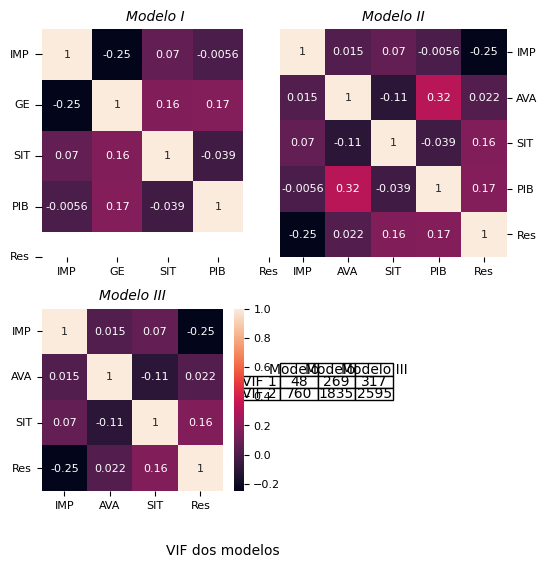

In [1429]:

# multiplot inserindo tabela 
X1 = ofestim[['IMP', 'grau_est', 'opind', 'var_anual_PIBpercapita', 'match_probtema_maincats']]
X2 = ofestim[['IMP', 'sit_econ2', 'opind', 'var_anual_PIBpercapita', 'match_probtema_maincats']]
X3 = ofestim[['IMP', 'sit_econ2', 'opind', 'match_probtema_maincats']]

# Correlation matrix
sns.set_style(rc={'ytick.left': True})

#plt.figure(figsize=(6,5))

fig, axes = plt.subplot_mosaic([[0,1], [2, 3]], height_ratios=[5,4], figsize=(6, 6))

# plot correlation matrix
h1 = sns.heatmap(X.corr(), annot=True, xticklabels = ['IMP', 'GE', 'SIT', 'PIB', 'Res'],
                yticklabels = ['IMP', 'GE', 'SIT', 'PIB', 'Res'], cbar = False, annot_kws={'fontsize': 8}, ax = axes[0])
axes[0].tick_params(labelsize=8)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0) 
axes[0].tick_params(axis='y', which='both', length=5)  # length ajusta o comprimento dos ticks
axes[0].set_title('Modelo I', fontsize=10, style ='italic')


h2 = sns.heatmap(X2.corr(), annot=True, xticklabels = ['IMP', 'AVA', 'SIT', 'PIB', 'Res'],
            yticklabels = ['IMP', 'AVA', 'SIT', 'PIB', 'Res'], cbar = False, annot_kws={'fontsize': 8}, ax = axes[1])
axes[1].tick_params(labelsize=8)
axes[1].yaxis.tick_right()
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0) 
axes[1].set_title('Modelo II', fontsize=10, style ='italic')

h3 = sns.heatmap(X3.corr(), annot=True, xticklabels = ['IMP', 'AVA', 'SIT', 'Res'],
            yticklabels = ['IMP', 'AVA', 'SIT', 'Res'], cbar = True, annot_kws={'fontsize': 8}, ax = axes[2])
axes[2].tick_params(labelsize=8)
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=0) 
axes[2].set_title('Modelo III', fontsize=10, style ='italic')

cbar = h3.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
axes[3].axis('off')
##
# Dados da tabela (valores numéricos)
data = [
    [48, 269, 317],
    [760, 1835, 2595]
]


# Posicionamento da tabela usando plt.table()
table = axes[3].table(cellText=data,
                 rowLabels=['VIF 1', 'VIF 2'],
                 colLabels=['Modelo I', 'Modelo II', 'Modelo III'],
                 loc='center', cellLoc='center', bbox=[0, 0.5, 0.5, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1)  # Ajusta o tamanho da tabela


# Adicionando título
axes[3].annotate('VIF dos modelos', (0, -0.35), xycoords='axes fraction', ha='right', fontsize=10)
#axes[3].set_title('VIF dos modelos antes e\npós centralização', fontsize)

# Adicionando fonte abaixo da tabela
#axes[3].text(0, 0, "Fonte: Elaborado pelo autor", ha='center', va='center', transform=ax.transAxes)
##
plt.subplots_adjust(wspace=0.05, hspace = 0.25)
plt.show()


Colocar este último modelo de R2 de 0.1755, descrevendo o que fiz e comparando com possíveis modelos alternativos:
- Usei percepção da avaliação econômica para calcular o grau de estresse, e PIB para avaliar impacto da economia na situação da campanha (também para evitar multicolinearidade - comparar o VIF substituindo entre si os indicadores);
- Mostrar como mediquei a multicolinearidade: centralizei as variáveis ("(Aiken & West, 1991) to improve the interpretation of the lower order effects, β 1 and β 2, sometimes referred to as main effects. Centering or creating deviation scores, which involves subtracting the mean from each predictor’s original value, reduces multicollinearity among the predictors when these new variables are used in the model - https://web.pdx.edu/~newsomj/cdaclass/ho_interactions.pdf), mostrar o antes e depois do VIF e o heatmap
- Usar aqueles testes de chow nao sei o que só pra ver se alguma observação está enviesando muito o modelo.

# Plotar o gráfico de probabilidades

## Calculating probabilities straight from the model

In [10]:

# Model

model1 = smf.logit("Eleito ~ IMP*sit_econ2 + C(opind)*var_anual_PIBpercapita + match_probtema_maincats", data = av).fit()

# Generating sample with original IMP range
IMP_range = np.linspace(av['IMP'].min(), av['IMP'].max(), 100)

#Probabilities database for situation, match = 0, inferior percentil econ

# Fixing covariates values

sit_econ2_fix = av.sit_econ2.min()
opind_fix = 0
pib_mean = av.var_anual_PIBpercapita.mean()
match_probtema_maincats_fix = 0

# Dataframe with the covariates to predict
sitinf = pd.DataFrame({
    'IMP': IMP_range,
    'sit_econ2': sit_econ2_fix,
    'opind': opind_fix,
    'var_anual_PIBpercapita': pib_mean,
    'match_probtema_maincats': match_probtema_maincats_fix
})

# Adding interactions
sitinf['IMP*sit_econ2'] = sitinf['IMP'] * sitinf['sit_econ2']
sitinf['C(opind)[T.{opind_mode}]'] = 0  # Include categorical variable opind
sitinf['C(opind)[T.{opind_mode}]*var_anual_PIBpercapita'] = sitinf['var_anual_PIBpercapita']

# Predict probabilities
sitinf = model1.predict(sitinf)

#Probabilities database for situation, match = 0, superior percentil econ

# Fixing covariates values

sit_econ2_fix = av.sit_econ2.max()
opind_fix = 0
pib_mean = av.var_anual_PIBpercapita.mean()
match_probtema_maincats_fix = 0

# Dataframe with the covariates to predict
sitsup = pd.DataFrame({
    'IMP': IMP_range,
    'sit_econ2': sit_econ2_fix,
    'opind': opind_fix,
    'var_anual_PIBpercapita': pib_mean,
    'match_probtema_maincats': match_probtema_maincats_fix
})

# Adding interactions
sitsup['IMP*sit_econ2'] = sitsup['IMP'] * sitsup['sit_econ2']
sitsup['C(opind)[T.{opind_mode}]'] = 0  # Include categorical variable opind
sitsup['C(opind)[T.{opind_mode}]*var_anual_PIBpercapita'] = sitsup['var_anual_PIBpercapita']

# Predict probabilities
sitsup = model1.predict(sitsup)

#Probabilities database for oposition, match = 0, inferior percentil econ

# Fixing covariates values

sit_econ2_fix = av.sit_econ2.min()
opind_fix = 1 
pib_mean = av.var_anual_PIBpercapita.mean()
match_probtema_maincats_fix = 0

# Dataframe with the covariates to predict
opinf = pd.DataFrame({
    'IMP': IMP_range,
    'sit_econ2': sit_econ2_fix,
    'opind': opind_fix,
    'var_anual_PIBpercapita': pib_mean,
    'match_probtema_maincats': match_probtema_maincats_fix
})

# Adding interactions
opinf['IMP*sit_econ2'] = opinf['IMP'] * opinf['sit_econ2']
opinf['C(opind)[T.{opind_mode}]'] = 1  # Include categorical variable opind
opinf['C(opind)[T.{opind_mode}]*var_anual_PIBpercapita'] = opinf['var_anual_PIBpercapita']

# Predict probabilities
opinf = model1.predict(opinf)

#Probabilities database for oposition, match = 0, superior percentil econ

# Fixing covariates values

sit_econ2_fix = av.sit_econ2.max()
opind_fix = 1 
pib_mean = av.var_anual_PIBpercapita.mean()
match_probtema_maincats_fix = 0

# Dataframe with the covariates to predict
opsup = pd.DataFrame({
    'IMP': IMP_range,
    'sit_econ2': sit_econ2_fix,
    'opind': opind_fix,
    'var_anual_PIBpercapita': pib_mean,
    'match_probtema_maincats': match_probtema_maincats_fix
})

# Adding interactions
opsup['IMP*sit_econ2'] = opsup['IMP'] * opsup['sit_econ2']
opsup['C(opind)[T.{opind_mode}]'] = 1  # Include categorical variable opind
opsup['C(opind)[T.{opind_mode}]*var_anual_PIBpercapita'] = opsup['var_anual_PIBpercapita']

# Predict probabilities
opsup = model1.predict(opsup)

Optimization terminated successfully.
         Current function value: 0.539078
         Iterations 6


In [12]:

#Probabilities database for situation, match = 0, inferior percentil econ

# Fixing covariates values

sit_econ2_fix = av.sit_econ2.min()
opind_fix = 0
pib_mean = av.var_anual_PIBpercapita.mean()
match_probtema_maincats_fix = 1

# Dataframe with the covariates to predict
sitinfma = pd.DataFrame({
    'IMP': IMP_range,
    'sit_econ2': sit_econ2_fix,
    'opind': opind_fix,
    'var_anual_PIBpercapita': pib_mean,
    'match_probtema_maincats': match_probtema_maincats_fix
})

# Adding interactions
sitinfma['IMP*sit_econ2'] = sitinfma['IMP'] * sitinfma['sit_econ2']
sitinfma['C(opind)[T.{opind_mode}]'] = 0  # Include categorical variable opind
sitinfma['C(opind)[T.{opind_mode}]*var_anual_PIBpercapita'] = sitinfma['var_anual_PIBpercapita']

# Predict probabilities
sitinfma = model1.predict(sitinfma)

#Probabilities database for situation, match = 1, superior percentil econ

# Fixing covariates values

sit_econ2_fix = av.sit_econ2.max()
opind_fix = 0
pib_mean = av.var_anual_PIBpercapita.mean()
match_probtema_maincats_fix = 1

# Dataframe with the covariates to predict
sitsupma = pd.DataFrame({
    'IMP': IMP_range,
    'sit_econ2': sit_econ2_fix,
    'opind': opind_fix,
    'var_anual_PIBpercapita': pib_mean,
    'match_probtema_maincats': match_probtema_maincats_fix
})

# Adding interactions
sitsupma['IMP*sit_econ2'] = sitsupma['IMP'] * sitsupma['sit_econ2']
sitsupma['C(opind)[T.{opind_mode}]'] = 0  # Include categorical variable opind
sitsupma['C(opind)[T.{opind_mode}]*var_anual_PIBpercapita'] = sitsupma['var_anual_PIBpercapita']

# Predict probabilities
sitsupma = model1.predict(sitsupma)

#Probabilities database for oposition, match = 1, inferior percentil econ

# Fixing covariates values

sit_econ2_fix = av.sit_econ2.min()
opind_fix = 1 
pib_mean = av.var_anual_PIBpercapita.mean()
match_probtema_maincats_fix = 1

# Dataframe with the covariates to predict
opinfma = pd.DataFrame({
    'IMP': IMP_range,
    'sit_econ2': sit_econ2_fix,
    'opind': opind_fix,
    'var_anual_PIBpercapita': pib_mean,
    'match_probtema_maincats': match_probtema_maincats_fix
})

# Adding interactions
opinfma['IMP*sit_econ2'] = opinfma['IMP'] * opinfma['sit_econ2']
opinfma['C(opind)[T.{opind_mode}]'] = 1  # Include categorical variable opind
opinfma['C(opind)[T.{opind_mode}]*var_anual_PIBpercapita'] = opinfma['var_anual_PIBpercapita']

# Predict probabilities
opinfma = model1.predict(opinfma)

#Probabilities database for oposition, match = 1, superior percentil econ

# Fixing covariates values

sit_econ2_fix = av.sit_econ2.max()
opind_fix = 1 
pib_mean = av.var_anual_PIBpercapita.mean()
match_probtema_maincats_fix = 1

# Dataframe with the covariates to predict
opsupma = pd.DataFrame({
    'IMP': IMP_range,
    'sit_econ2': sit_econ2_fix,
    'opind': opind_fix,
    'var_anual_PIBpercapita': pib_mean,
    'match_probtema_maincats': match_probtema_maincats_fix
})

# Adding interactions
opsupma['IMP*sit_econ2'] = opsupma['IMP'] * opsupma['sit_econ2']
opsupma['C(opind)[T.{opind_mode}]'] = 1  # Include categorical variable opind
opsupma['C(opind)[T.{opind_mode}]*var_anual_PIBpercapita'] = opsupma['var_anual_PIBpercapita']

# Predict probabilities
opsupma = model1.predict(opsupma)

## Plotting the graphs 

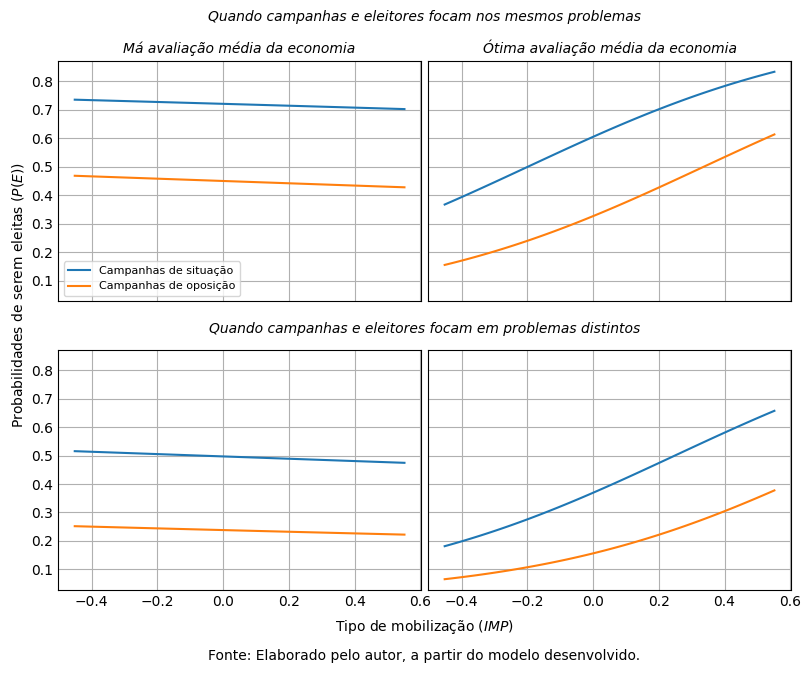

In [41]:
sitinfunmat = pd.read_csv('Bases finais/Probabilidades preditas/sitinfunmat.csv')
IMP_range = sitinfunmat.IMP
sitinf = sitinfunmat.predict

opinfunmat = pd.read_csv('Bases finais/Probabilidades preditas/opinfunmat.csv')
opinf = opinfunmat.predict

sitsupunmat = pd.read_csv('Bases finais/Probabilidades preditas/sitsupunmat.csv')
sitsup = sitsupunmat.predict

opsupunmat = pd.read_csv('Bases finais/Probabilidades preditas/opsupunmat.csv')
opsup = opsupunmat.predict

sitinfmat = pd.read_csv('Bases finais/Probabilidades preditas/sitinfmat.csv')
sitinfma = sitinfmat.predict

opinfmat = pd.read_csv('Bases finais/Probabilidades preditas/opinfmat.csv')
opinfma = opinfmat.predict

sitsupmat = pd.read_csv('Bases finais/Probabilidades preditas/sitsupmat.csv')
sitsupma = sitsupmat.predict

opsupmat = pd.read_csv('Bases finais/Probabilidades preditas/opsupmat.csv')
opsupma = opsupmat.predict

# Plotar os resultados
fig, axes = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(8, 6))

# Gráfico 1 - Percentil inferior
# sitinfmat
axes[0,0].plot(IMP_range, sitinfma, label = 'Campanhas de situação', color='#1f77b4')
axes[0,0].plot(IMP_range, opinfma, label = 'Campanhas de oposição', color = '#ff7f0e')
#axes[0,0].set_xlabel('IMP')
#axes[0,0].set_ylabel('P(E)')
axes[0,0].set_title('Má avaliação média da economia', style = 'italic', fontsize = 10)
axes[0,0].legend(fontsize = 8, loc = 'lower left')
axes[0,0].grid(True)
axes[0,0].tick_params(axis='both', length=0)
axes[0,0].set_yticks(np.arange(0, 7, 0.1))

# Gráfico 2 - Percentil superior
axes[0,1].plot(IMP_range, sitsupma, label = 'Campanhas de situação', color='#1f77b4')
axes[0,1].plot(IMP_range, opsupma, label = 'Campanhas de oposição', color = '#ff7f0e')
#axes[0,1].set_xlabel('IMP')
#axes[0,1].set_ylabel('P(E)')
axes[0,1].set_title('Ótima avaliação média da economia', style = 'italic', fontsize = 10)
#axes[0,1].legend(fontsize = 8)
axes[0,1].grid(True)
axes[0,1].tick_params(axis='both', length=0)

# Gráfico 3 - Percentil inferior
# sitinfunmat
axes[1,0].plot(IMP_range, sitinf, label = 'Campanhas de situação', color='#1f77b4')
axes[1,0].plot(IMP_range, opinf, label = 'Campanhas de oposição', color = '#ff7f0e')
#axes[1,0].set_xlabel('IMP')
#axes[1,0].set_ylabel('P(E)')
#axes[1,0].legend(fontsize=8)
axes[1,0].grid(True)
axes[1,0].tick_params(axis='both', length=0)
axes[1,0].set_yticks(np.arange(0, 7, 0.1))

# Gráfico 4 - Percentil superior
axes[1,1].plot(IMP_range, sitsup)
axes[1,1].plot(IMP_range, opsup)
#axes[1,1].set_xlabel('IMP')
#axes[1,1].set_ylabel('P(E)')
#axes[1,1].legend()
axes[1,1].grid(True)
axes[1,1].tick_params(axis='both', length=0)

# Responsivity 0 

fig.text(
    0.51, 1,
    "Quando campanhas e eleitores focam nos mesmos problemas",
    ha="center",
    va="bottom",    
    color="black",
    fontsize=10, style = 'italic'
)

# Responsivity 1 

fig.text(
    0.51, 0.48,
    "Quando campanhas e eleitores focam em problemas distintos",    
    ha="center",
    va="bottom",    
    color="black",
    fontsize=10, style = 'italic'
)


# Y label

plt.text(
    -1.75, 1.53,
    "Probabilidades de serem eleitas ($P(E)$)",
    ha="center",
    va="top",    
    fontsize=10, 
    color="black", rotation=90
)

# X Label

fig.text(
    0.51, -0.02,
    "Tipo de mobilização ($IMP$)",
    ha="center",
    va="bottom",    
    color="black",
    fontsize=10
)

# footnote source 

fig.text(
    0.51, -0.065,
    "Fonte: Elaborado pelo autor, a partir do modelo desenvolvido.",
    ha="center",
    va="bottom",    
    color="black",
    fontsize=10
)


plt.tight_layout()
fig.subplots_adjust(hspace = 0.2, wspace=0.02)
#plt.show()


- A tendência paralela entre as retas mostra que o efeito de X em Y é o mesmo tanto para campanhas de situação quanto de oposição.

In [ ]:
sns.regplot = (x = 'IMP', y = '')

In [63]:
predicted_probs

0     2.422013e-10
1     2.358753e-10
2     2.297145e-10
3     2.237146e-10
4     2.178715e-10
          ...     
95    1.959940e-11
96    1.908748e-11
97    1.858894e-11
98    1.810342e-11
99    1.763058e-11
Length: 100, dtype: float64